<a href="https://colab.research.google.com/github/limjunghyeon/ESAA_py/blob/main/ESAAHW_0508_pg_227~251%2C_278~289.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#06. XGBoost

트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘. 다른 머신러닝보다 뛰어난 예측 성능.
GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제를 해결해서 매우 각광 받고 있음.

*주요 장점*

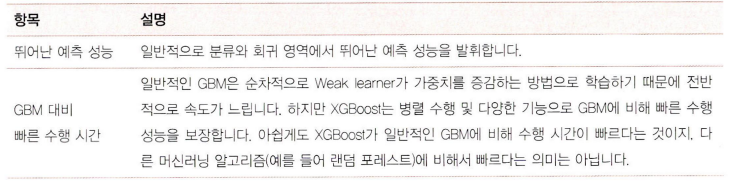

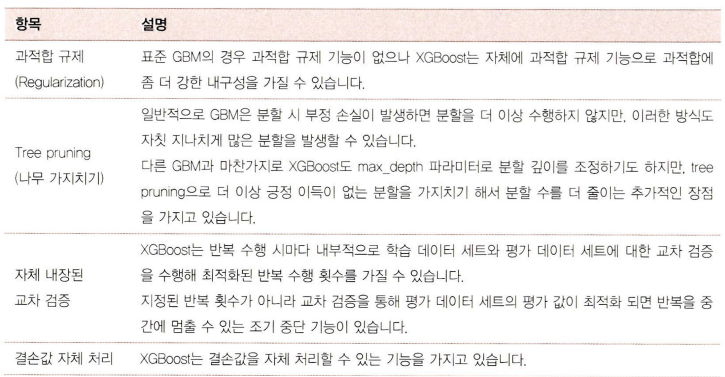

-파이썬 패키지 명 : xgboost


**XGBOOST 설치하기**

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

**XGBoost 하이퍼 파라미터**

*일반 파라미터 *

: 일반적으로 실행 시 스레드 개수나 silent 모드 등의 선택을 위한 파라미터로 디폴트 파라미터 값을 바꾸는 경우는 거의 없음

-부스터 파라미터

: 트리 최적화, 부스팅 regularization 등과 관련 파라미터 등을 지칭.

-학습 태스크 파라미터

:학습 수행 시의 객체 함수. 평가를 위한 지표 등을 설정하는 파라미터



*주요 일반 파라미터*

-booster : gbtree(디폴트), gblinear 선택.

-silent : 디폴트는 0. 출력 메세지 나타내고 싶지 않으면 1.

-nthread : cpu의 실행 스레드 개수를 조정. 디폴트는 CPU 전체 스레드 다 사용. 멀티 코어/스레드 CPU 시스템에서 전체 CPU 사용하지않고 일부 CPU만 사용해 ML 애플리켕션을 구동하는 경우에 변경.


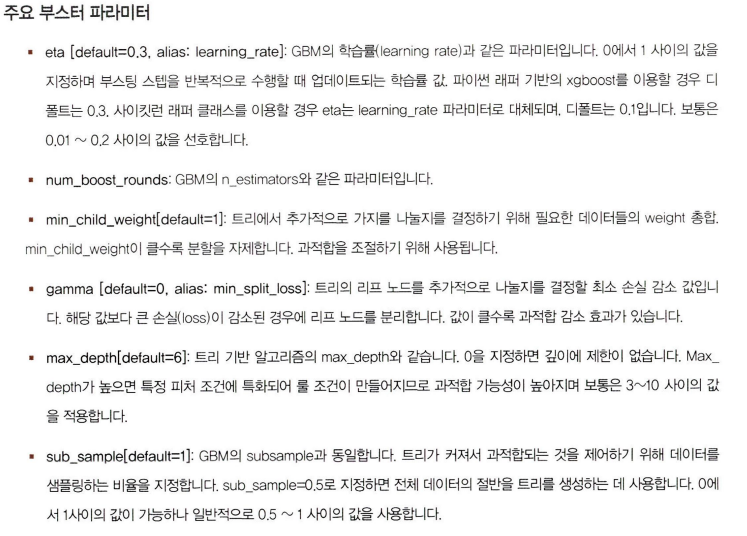

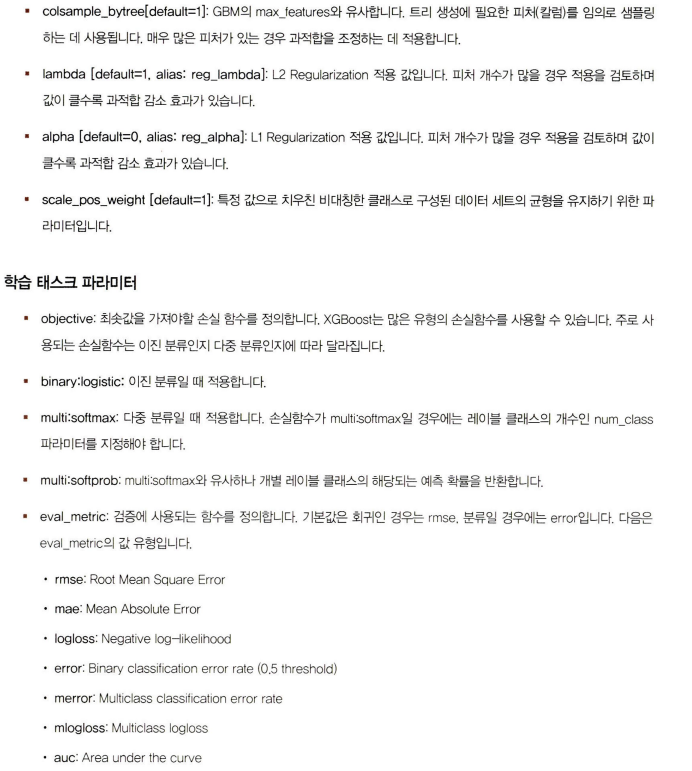

**과적합 문제가 심각할 경우 고려사항**

-eta 값을 낮춤(0.01~0.1) eta 값을 낮출 경우 num_round는 반대로 높여줘야함

-max_depth 값을 낮춰줌

-min_child_weight 값을 높임

-gamma 값 높임

-또한 subsample과 colsample_bytree 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움이 될 수 있음

In [ ]:
import xgboost
print(xgboost.__version__)

1.7.5


#파이썬 래퍼 CGBoost 적용 - 위스콘신 유방암 예측

XGBoost의 파이썬 패키지인 xgboost는 자체적으로 교차검증, 성능 평가, 피처 중요도 등의 시각화 기능 갖고 있음.

조기 중단 기능이 있어서 num_rounds로 지정한 부스팅 반복 횟수에 도달하지 않아도 더 이상 예측 오류가 개선되지 않으면 중지해 수행시간 개선하는 기능도 갖고있음.


In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#악성인  malignant가 0의 값으로, 양성인 benign이 1 값으로
dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target
cancer_df=pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

mean radius  mean texture  ...  worst fractal dimension  target
0        17.99         10.38  ...                  0.11890       0
1        20.57         17.77  ...                  0.08902       0
2        19.69         21.25  ...                  0.08758       0

[3 rows x 31 columns]

In [ ]:
# 레이블 값의 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, 
                                                  test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [ ]:
#넘파이 형태의 학습 데이터 세트와 테스트 데이터 세트를 DMatrix로 변환

dtrain=xgb.DMatrix(data=X_train, label=y_train)
dtest=xgb.DMatrix(data=X_test, label=y_test)

다음은 하이터 파라미터 설정을 딕셔너리 형태로
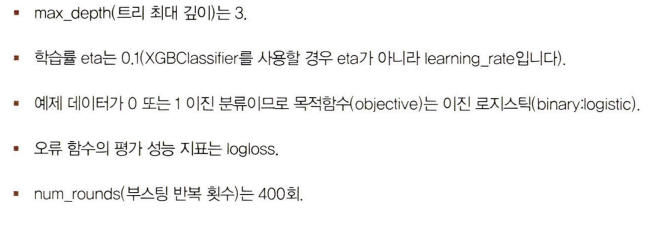

In [ ]:
params={'max_depth':3,  
        'eta':0.1,  # learning rate
        'objective':'binary:logistic', # 이진 분류이기 때문에 목적함수는 이진 로지스틱  
        'eval_metric':'logloss',  # 오류 함수의 평가 성능 지표
        'early_stoppings':100 
        }
num_rounds=400

**XGBoost 모델 학습**

하이퍼 파라미터를 xgboost 모듈의 train() 함수에 파라미터로 전달.

조기중단은 xgboost의 train() 함수에 early_stopping_rounds 파라미터를 입력해 설정

-eval_set : 성능 평가를 수행할 평가용 데이터 세트 설정

-eval_metric은 평가 세트에 적용할 성능 평가 방법, 분류일 경우 주로 error, logloss 적용



In [ ]:
# train 데이터 세트는 'train', evalution(test) 데이터 세트는 'eval'로 명기합니다.
wlist=[(dtrain, 'train'), (dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model=xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[16:22:08] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoppings" } are not used.

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	

**테스트 데이터 세트에 예측을 수행**

-사이킷런의 prediect(): 예측 결과 클래스 값을 반환

-xgboost의 predict(): 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds=[ 1 if x>0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
#3장 평가에서 생성한 get_clf_Eval()함수를 적용해 XGBoost 모델의 예측 성능 평가

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


**XGboost 패키지에 내장된 시각화 기능**

**plot_importance() API**

: 피처의 중요도를 막대그래프 형식으로

유의점) xgboost 넘파이 기반의 피처 데이터로 학습 시에 피처명을 제대로 알 수 가 없으므로 f0, f1와 같이 피처 순서별로 f자 뒤에 순서를 붙여서 X 축에 피처들로 나열

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

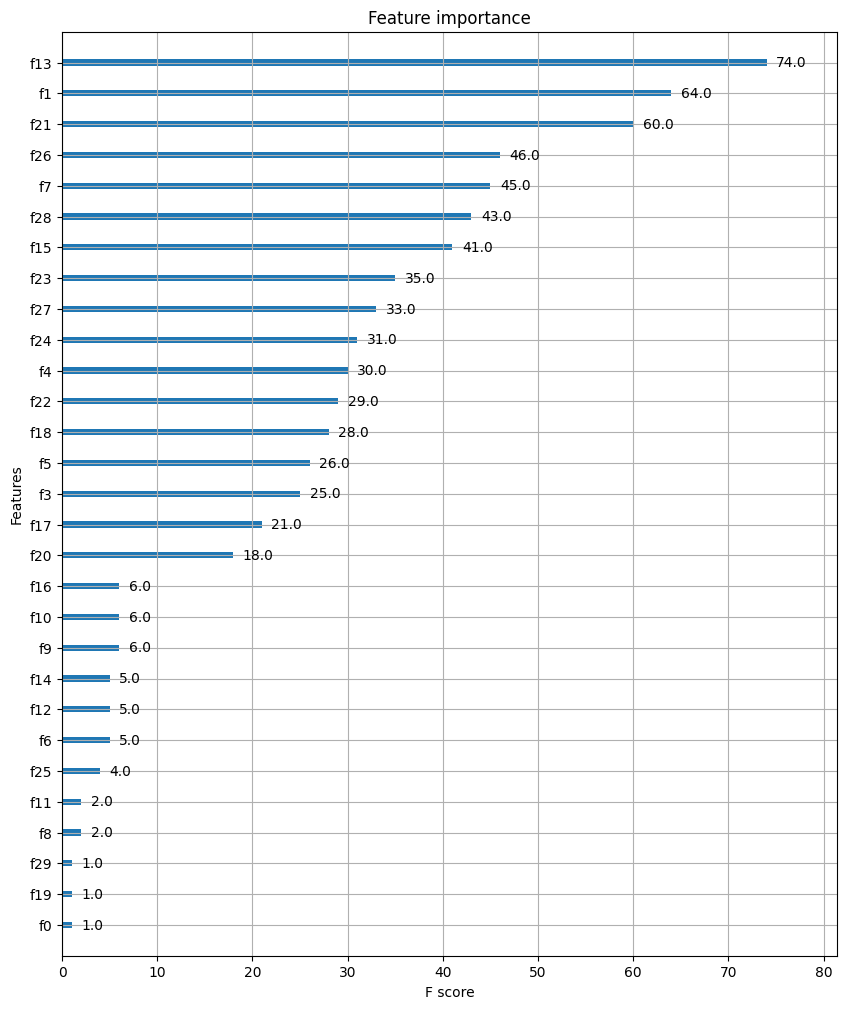

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax) 

#cv() API와 파라미터

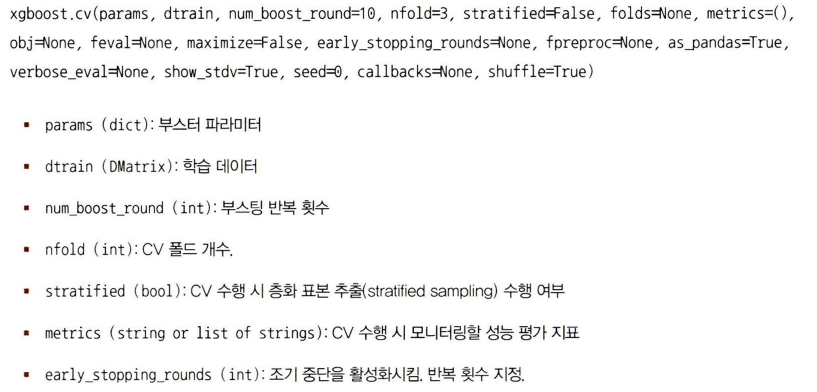



xgb.cv 반환값은 DataFrame 형태

#사이킷런 래퍼 XGBoost의 개요 및 적용

사이킷런을 위한 래퍼 XGBoost는 크게

-XGBlassifier : 분류
-XGBRegressor : 회귀


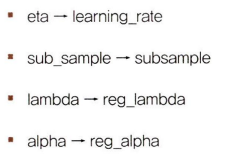



xgboost의 n_estimators와 num_boost_round 하이퍼 파라미터는 서로 동일한 파라미터

In [ ]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals=[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [ ]:
# 조기 중단으로 학습된 XGBCllassifier의 예측 성능
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [ ]:
# early_stopping_rounds를 10으로 설정
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

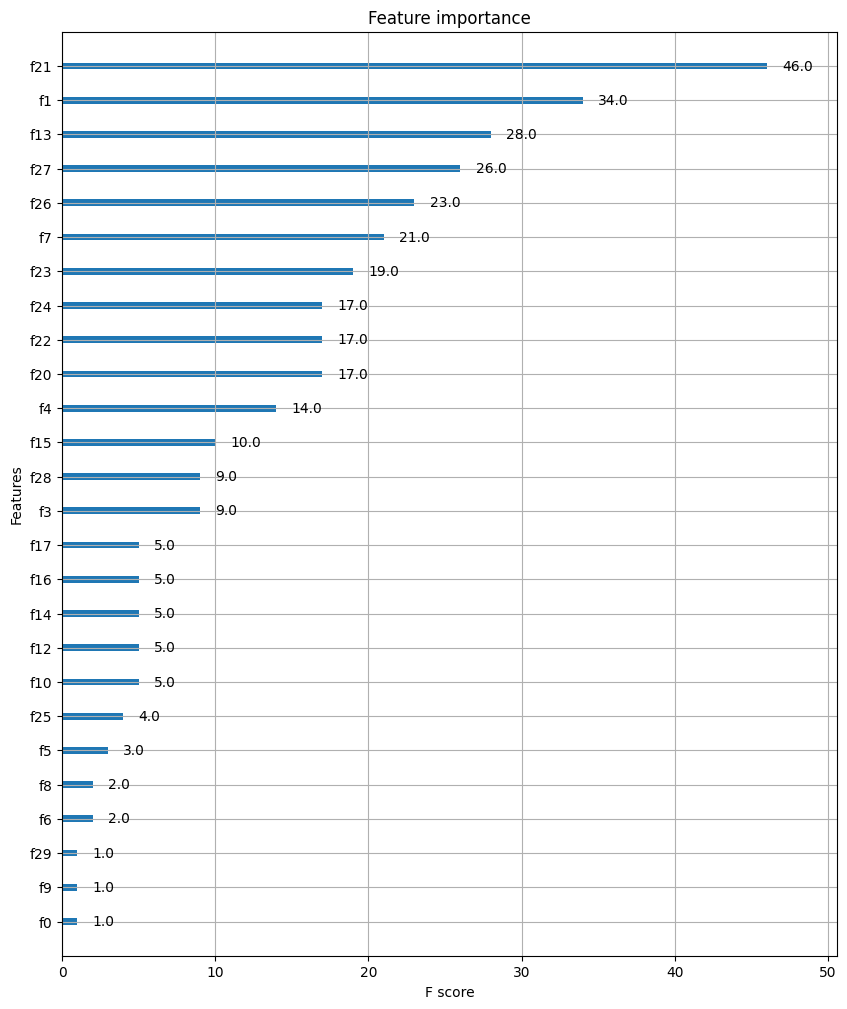

In [ ]:
#API에 사이킷런 래퍼 클래스 입력해도 앞에서 파이썬 래퍼 클래스 입력한 결과와 똑같은 시각화 결과

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

#07 LightGBM

xgboost는 매우 뛰어난 부스팅 알고리즘이지만, 여전히 학습 시간이 오래걸림


LightGBM의 가장 큰 장점은 XGBoost 보다 학습에 걸리는 시간이 훨씬 적음. 메모리 사용량도 적음.

일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 방식을 사용


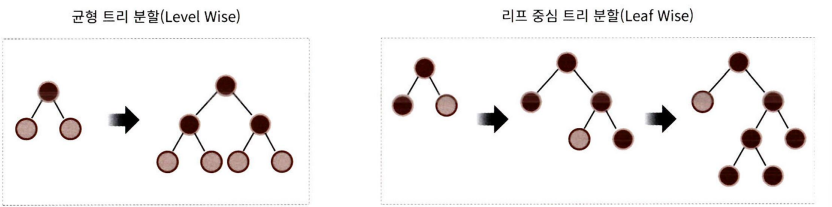



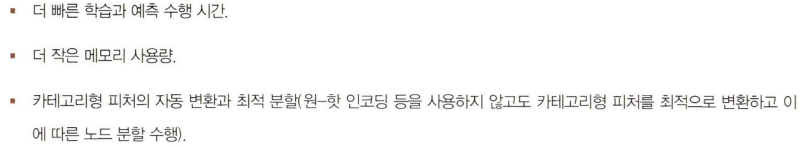

LightGBM의 파이썬 패키지명은 ightgbm


**LightGMB 하이퍼 파라미터**

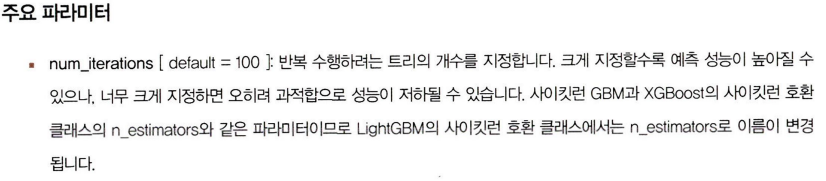

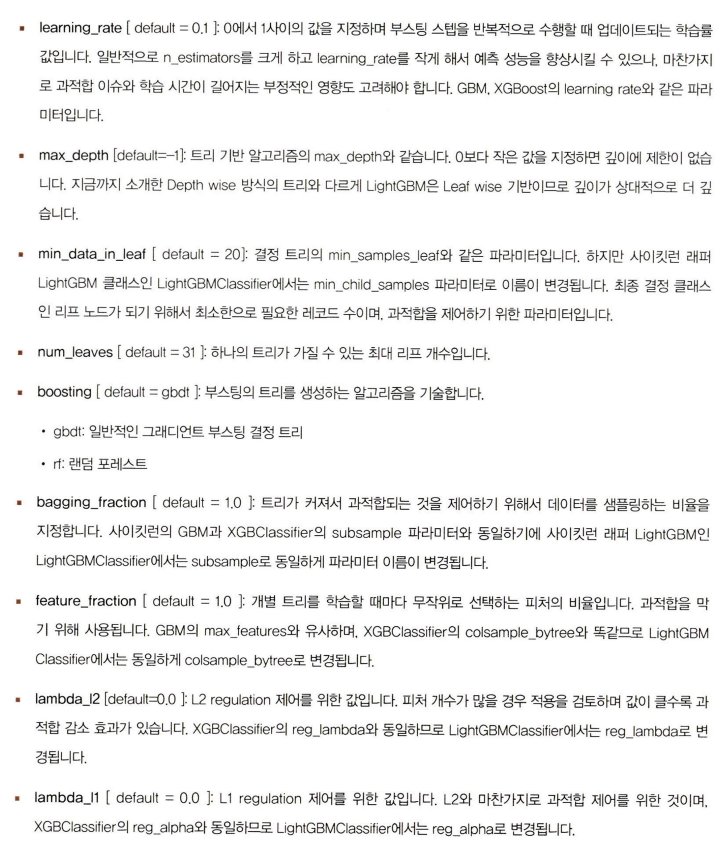

**learing Taske 파라미터**

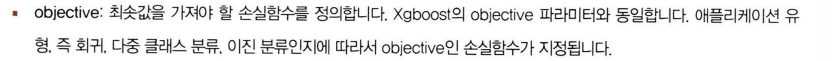

**하이퍼 파라미터 튜닝 방안**

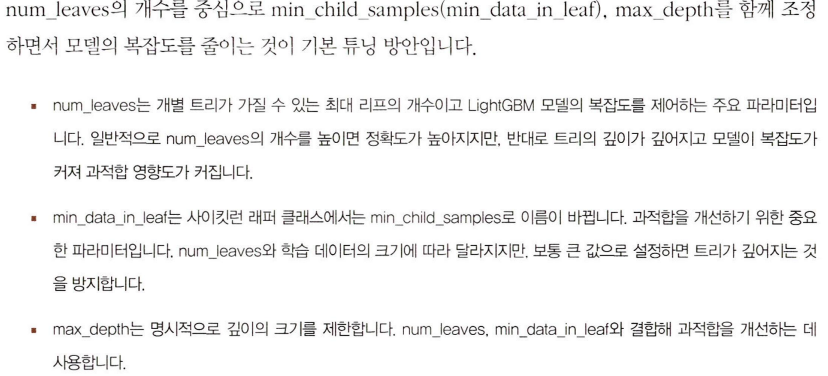

**파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교**

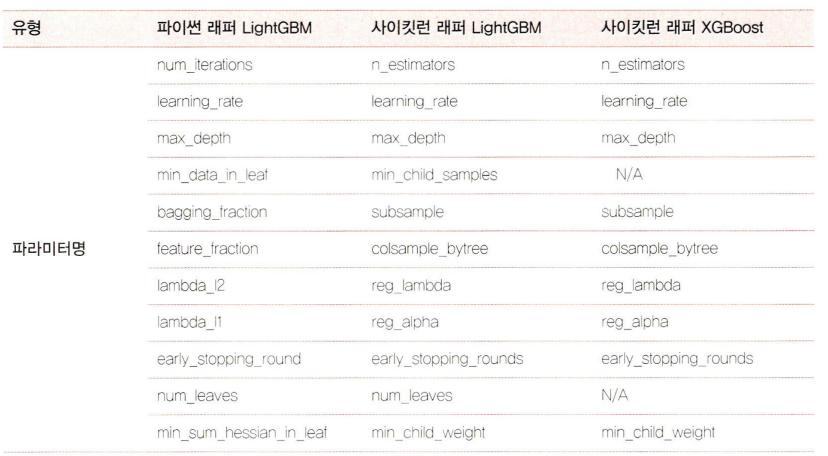

**LightGBM 적용 - 위스콘신 유방암 예측**



In [ ]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estmators는 400 설정
lgbm_wrapper=LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals=[(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', 
                 eval_set=evals, verbose=True)
pred=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]


[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9905


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

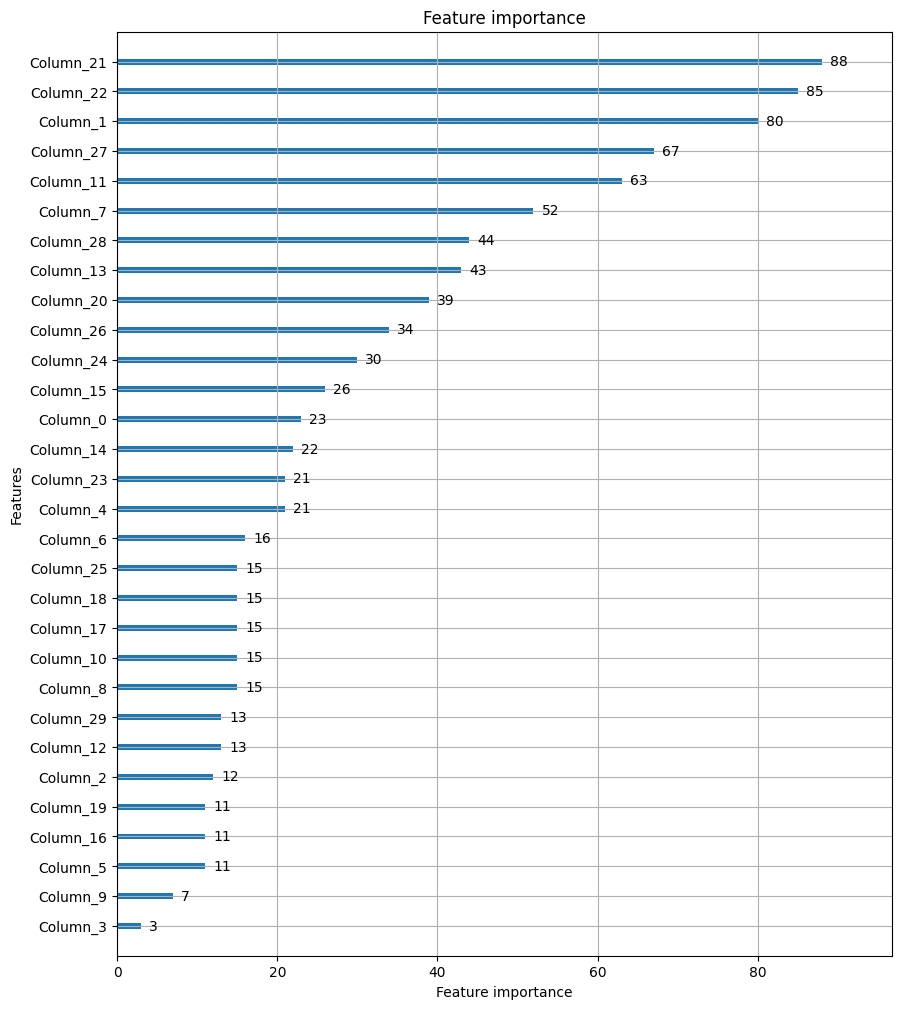

In [ ]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

#10 스태킹 앙상블

스태킹은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 앞에 소개한 배깅 및 부스팅과 공통점을 갖음.

큰 차이점은 개별 알고리즘으로 예측한 데이터를 기바능로 다시 예측을 수행한다는 것.

필요한 모델

1) 개별적인 기반 모델   2) 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델.


**기본 스태킹 모델**

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()
X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test=train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [ ]:
# 개별 모델은 KNN, 랜덤 포레스트, 결정 트리, 에이다부스트/ 이들 모델의 예측 결과를 합한 데이터 세트로 학습 및 예측하는 최종 모델은 로지스틱 회귀

# 개별 ML 모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

In [ ]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)



print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도:0.9211
랜덤 포레스트 정확도:0.9649
결정 트리 정확도:0.9035
에이다부스트 정확도:0.9561


In [ ]:
pred=np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [ ]:
# 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도 측정
lr_final.fit(pred, y_test)
final=lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도:0.9737


**CV 세트 기반의 스태킹**

-스탭1

: 각 모델별로 원본 학습/ 테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/ 테스트용 데이터를 생성


-스탭2

: 스텝 1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성.
메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터 레이블 데이터를 기반으로 평가



**3개의 폴드만큼 반복 수행하면서 스태킹 데이터를 생성하는 첫 번째 반복을 설명한 그림**


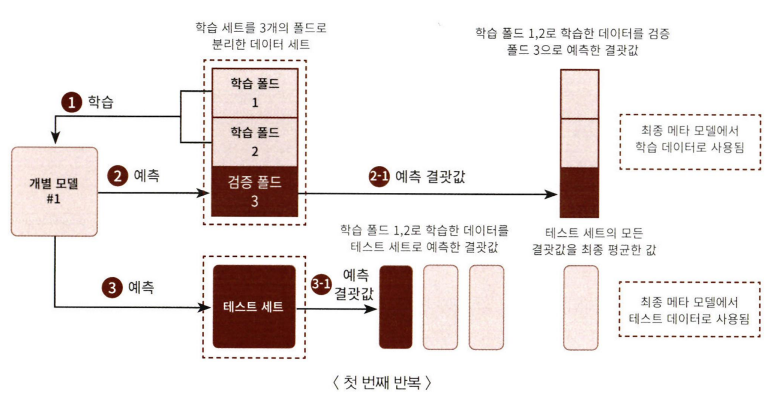





**스태킹 데이터를 생성하는 두 번째 반복을 설명. 폴드 내의 학습용 데이터 세트를 변경하고 첫 번째 그림과 동일한 작업을 수행**


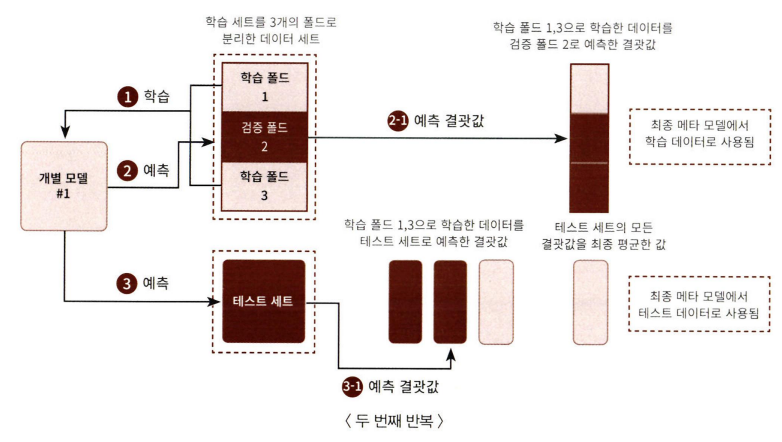






**세 번째 그림은 스태킹 데이터를 생성하는 세 번째 반복을 설명**

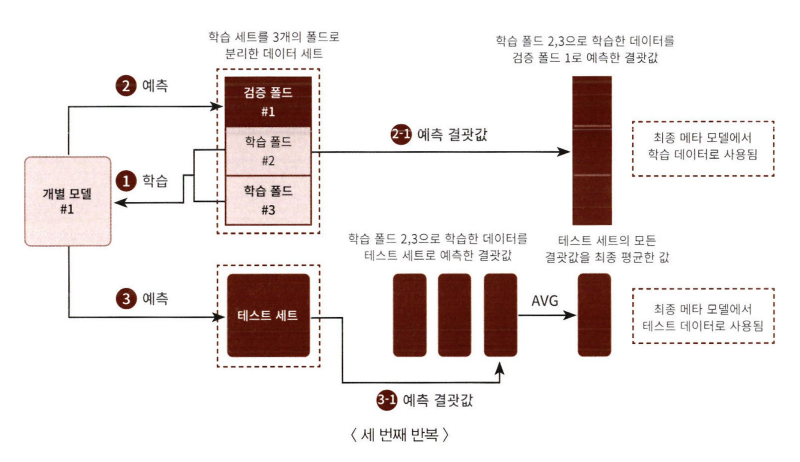

**마지막으로 스텝2에 관한 그림. 각 모델들이 스텝 1로 생성된 학습과 테스트 데이터를 모두 합쳐서 최종적으로 메타 모델이 사용할 학습 데이터와 테스트 데이터를 생성하기만 하면 됨.**

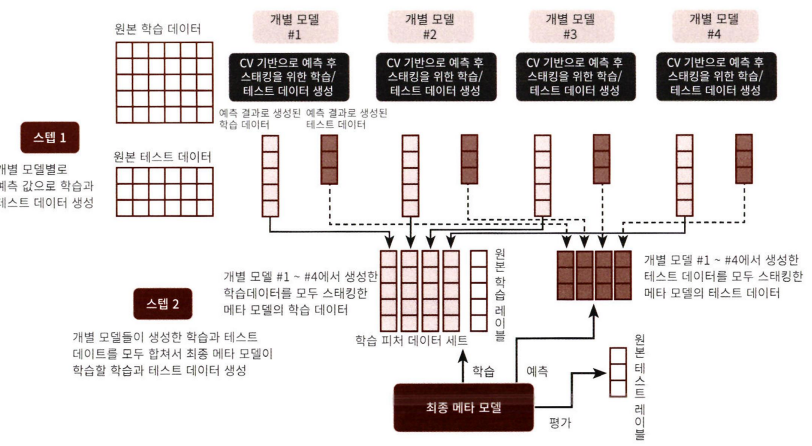

In [ ]:
#스텝1 코드로 구현

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits = n_folds, shuffle = True, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr=X_train_n[train_index] 
        y_tr=y_train_n[train_index] 
        X_te=X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장 
        test_pred[:, folder_counter]=model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
knn_train, knn_test=get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test=get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test=get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test=get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [ ]:
#스탭2
#concatenate() : 여러 개의 넘파이 배열을 칼럼 또는 로우 레벨로 합쳐줌
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:' ,X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:' , Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:' ,Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


#11 정리

앙상블 기법은 대표적으로 배깅과 부스팅

**1) 배깅**

: 학습 데이터를 중복을 허용하며넛 다수의 세트로 샘플링하여 이를 다수의 약한 학습기가 학습한 뒤 최종 결과를 결합해 예측. 대표적인 배깅 방식은 랜덤 포레스트(수행시간 빠르고 비교적 안정적인 예측 성능 제공)

**2) 부스팅**

: 현대는 배깅보다 부스팅이 더 주류. 학습기들이 순차적으로 학습을 진행하면서 예측이 틀린 데이터에 대해서는 가중치를 부여해 다음번 학습기가 학습할 때에는 이전에 예측이 틀린 데이터에 대해서는 보다 높은 정확도로 예측 가능. 부스팅의 효과적인 GBM은 뛰어난 예측 성능을 갖지만 수행시간이 너무 김.


**부스팅 기반 머신러닝에서 가장 각광 받는 패키지**

**1)XGBoost**


**2)LightGBM**


**스태킹 모델**

: 여러개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재 생성하는 기법. 핵심은 바로 메타 모델이 사용할 학습 데이터 세트와 예측 데이터 세트를 개별 모데르이 예측 값들을 스태킹 형태로 결합해 생성하는 데 있음.